In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

### 1. データの読み込み

In [2]:
df_origin = pd.read_csv("../ks-projects-201801.csv")

# データ表示
display(df_origin.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [10]:
# 有効データ数を確認
# いくつかデータ欠損しているカラムはあるが、最大使えるレコード数は「378661」レコード
display(df_origin.count())

ID                  378661
name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

In [11]:
# カラムのデータ型確認
# 数値であったほしいカラムは数値型であることを確認
display(df_origin.dtypes)

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [12]:
# 目的変数となるカラム「state」のユニークな値とその出現回数をカウント
display(df_origin["state"].value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

### 2. グラフ化

#### 2-1 グラフ化するためのデータを用意

In [3]:
# 「成功」か「失敗」だけのレコードを抽出(成功か失敗かで完了してしまっているデータ)
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]
# 抽出できたことを確認
display(df_success_or_failed["state"].value_counts())

failed        197719
successful    133956
Name: state, dtype: int64

In [4]:
# カテゴリ変数の数値化
# 不要だと思われる「ID」と「name」カラムは削除する
df_success_or_failed = df_success_or_failed.drop("ID", axis = 1)
df_success_or_failed = df_success_or_failed.drop("name", axis = 1)

In [5]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoderでカテゴリ変数を数値化
le = LabelEncoder()
# 「fit」と「transform」を分けることも出来る（fitで変換式を保存しておいて、fitの戻り値を使いまわすことができる）
# 数値化した列には「_class」を付加した列としてセットする
df_success_or_failed["category_class"] = le.fit_transform(df_success_or_failed["category"])
df_success_or_failed["main_category_class"] = le.fit_transform(df_success_or_failed["main_category"])
df_success_or_failed["currency_class"] = le.fit_transform(df_success_or_failed["currency"])
df_success_or_failed["state_class"] = le.fit_transform(df_success_or_failed["state"])
df_success_or_failed["country_class"] = le.fit_transform(df_success_or_failed["country"])

In [6]:
# カラムを並び変えたDataFrame作成
df_success_or_failed = df_success_or_failed.loc[:, ["category", "category_class",
                                                       "main_category", "main_category_class",
                                                        "state", "state_class",
                                                       "currency", "currency_class",
                                                       "deadline", "goal", "launched", "pledged",
                                                       "backers",
                                                       "country", "country_class",
                                                       "usd pledged", "usd_pledged_real", "usd_goal_real"]]
# 見やすいようにソートする
df_success_or_failed = df_success_or_failed.sort_values(by=["category_class", "main_category_class", "state_class"], 
                                                        ascending=[True, True, False])
display(df_success_or_failed.head())

,category,category_class,main_category,main_category_class,state,state_class,currency,currency_class,deadline,goal,launched,pledged,backers,country,country_class,usd pledged,usd_pledged_real,usd_goal_real
1000,3D Printing,0,Technology,13,successful,1,USD,13,2014-09-10,25000.0,2014-08-11 17:03:52,118923.50,290,US,22,118923.50,118923.50,25000.00
1084,3D Printing,0,Technology,13,successful,1,EUR,4,2015-06-11,30000.0,2015-05-12 09:42:41,40581.00,149,DE,5,45283.87,45531.66,33659.83
5028,3D Printing,0,Technology,13,successful,1,CAD,1,2013-10-20,50000.0,2013-09-20 23:21:14,651091.16,4420,CA,3,636502.52,623770.03,47901.90
8868,3D Printing,0,Technology,13,successful,1,CAD,1,2016-08-24,25000.0,2016-07-26 22:45:15,216288.98,84,CA,3,27244.69,167874.09,19403.91
10888,3D Printing,0,Technology,13,successful,1,USD,13,2017-04-24,30000.0,2017-03-21 17:20:36,254412.00,266,US,22,56808.00,254412.00,30000.00


クラウドファンディング前に分からない情報  
pledged：支援金の量  
backers：支援者数   
usd pledged：「pledged」をUSD換算したデータ(conversion made by KS)  
usd_pledged_real：「pledged」をUSD換算したデータ(conversion made by fixer.io api)  

これらは予測には使えないので削除する  

また「goal」の通貨は統一されていないので、USDで統一されている「usd_goal_real」を使用するので「goal」も削除する

In [7]:
for col in ["pledged", "backers", "usd pledged", "usd_pledged_real", "goal"]:
    df_success_or_failed = df_success_or_failed.drop(col, axis = 1)

「launched」と「deadline」はこのままでは使えないので、  
「launched」と「deadline」から「クラウドファンディング期間」という新しい説明変数を作る

In [8]:
launched_time = pd.to_datetime(df_success_or_failed["launched"], format = "%Y-%m-%d %H:%M:%S")
deadline_time = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S")
df_success_or_failed["term_days"] = (deadline_time - launched_time).dt.days

df_success_or_failed.head()

,category,category_class,main_category,main_category_class,state,state_class,currency,currency_class,deadline,launched,country,country_class,usd_goal_real,term_days
1000,3D Printing,0,Technology,13,successful,1,USD,13,2014-09-10,2014-08-11 17:03:52,US,22,25000.00,29
1084,3D Printing,0,Technology,13,successful,1,EUR,4,2015-06-11,2015-05-12 09:42:41,DE,5,33659.83,29
5028,3D Printing,0,Technology,13,successful,1,CAD,1,2013-10-20,2013-09-20 23:21:14,CA,3,47901.90,29
8868,3D Printing,0,Technology,13,successful,1,CAD,1,2016-08-24,2016-07-26 22:45:15,CA,3,19403.91,28
10888,3D Printing,0,Technology,13,successful,1,USD,13,2017-04-24,2017-03-21 17:20:36,US,22,30000.00,33


#### 2-2 グラフ化してみる

#### 散布図行列

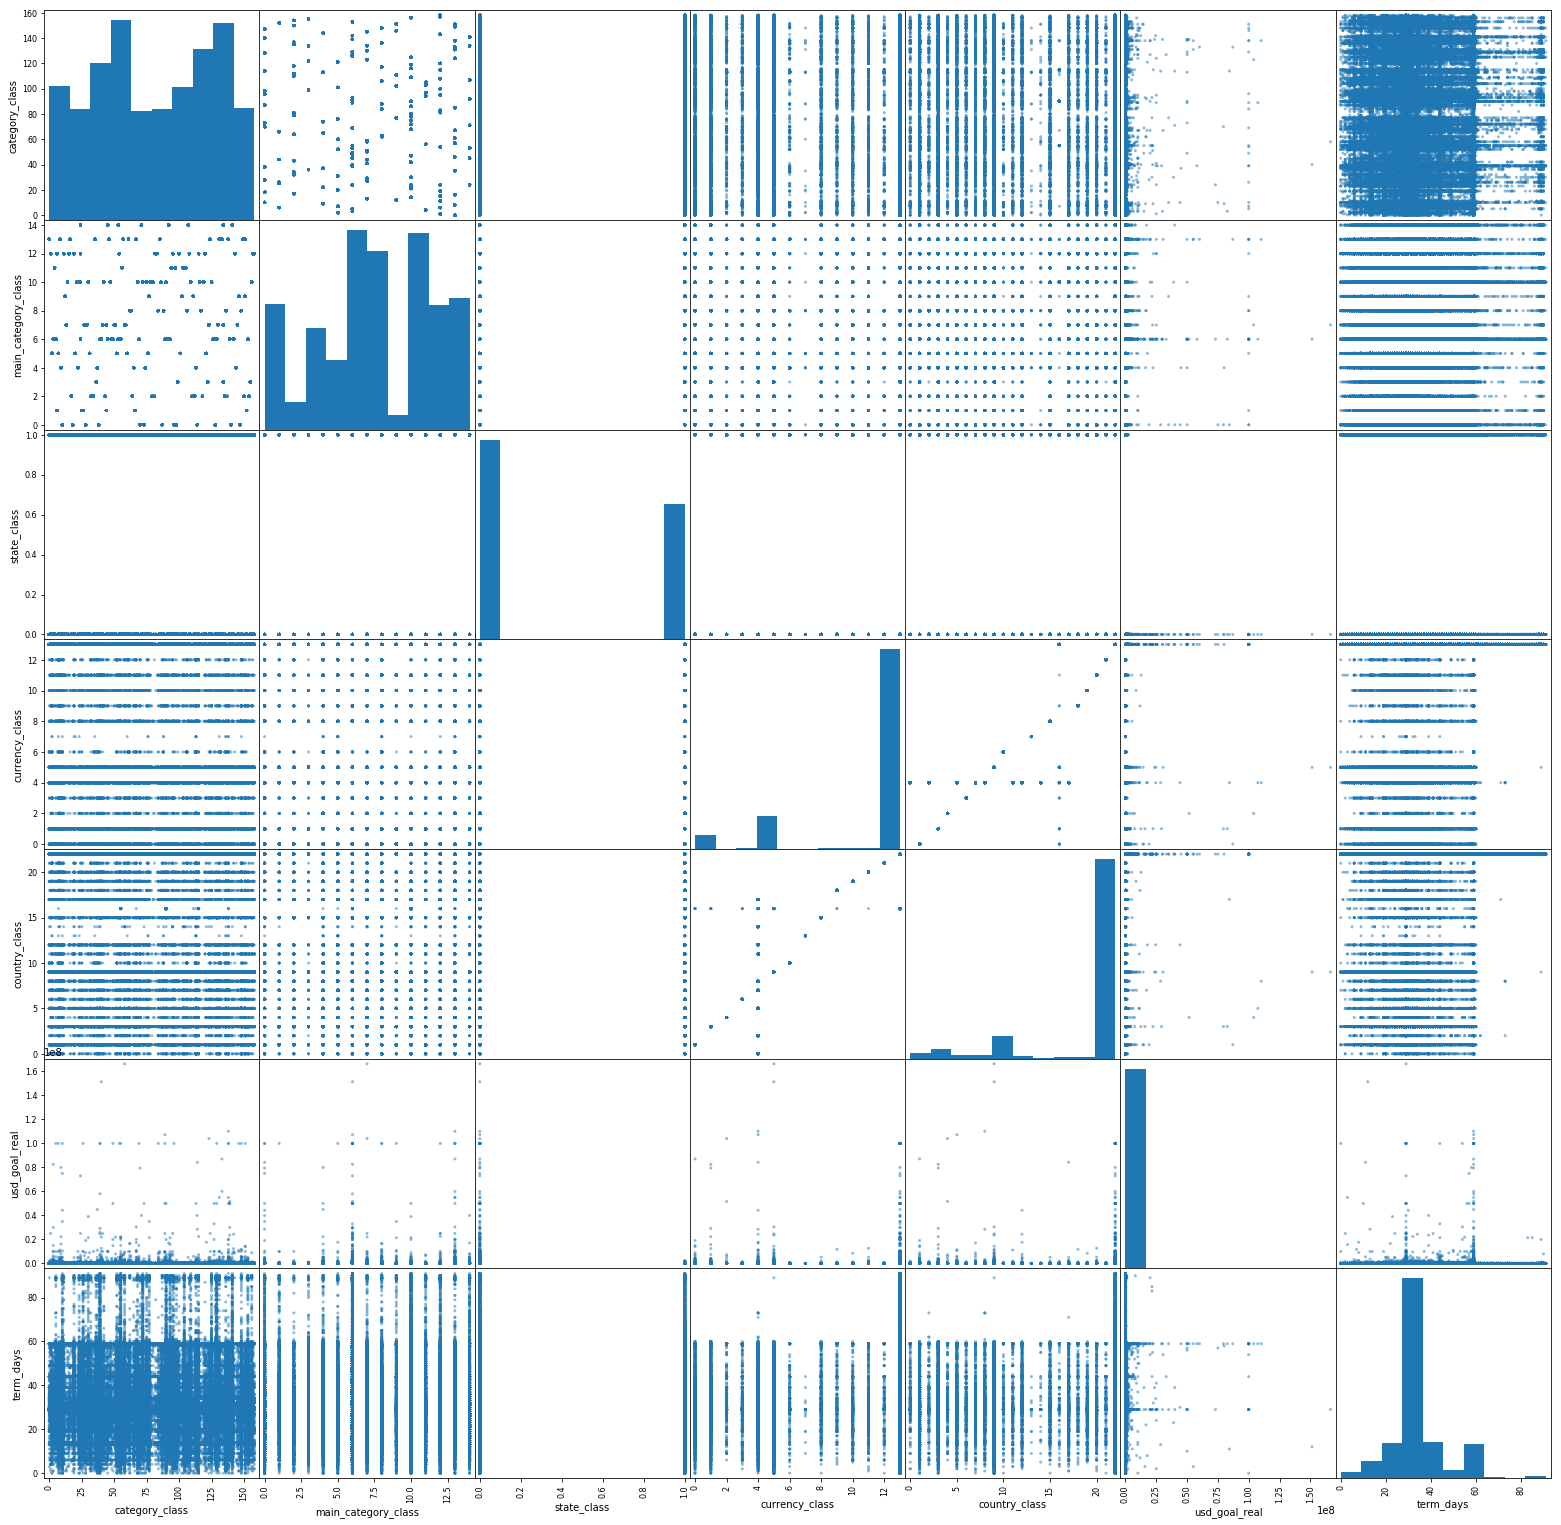

In [55]:
df_for_scatter_matrix = df_success_or_failed[["category_class", "main_category_class", "state_class", "currency_class", "country_class", "usd_goal_real", "term_days"]]
pd.plotting.scatter_matrix(df_for_scatter_matrix, figsize = (27, 27))
plt.show()
#plt.savefig("scatter_matrix.png") ←真っ白な画像が出力された

メモ
「usd_goal_real」と「state_class」から、目標金額が大きいと成功していないことが伺える
説明変数間の相関はないように思われる(「currency_class」と「country_class」はいいとして)

In [58]:
df_success_or_failed.corr()

,category_class,main_category_class,state_class,currency_class,country_class,usd_goal_real,term_days
category_class,1.000000,0.199748,0.033861,-0.009132,-0.009640,0.001101,-0.003213
main_category_class,0.199748,1.000000,-0.032147,-0.011872,-0.010828,0.000886,0.038525
state_class,0.033861,-0.032147,1.000000,0.059021,0.054805,-0.023735,-0.116437
currency_class,-0.009132,-0.011872,0.059021,1.000000,0.985873,-0.004494,0.029466
country_class,-0.009640,-0.010828,0.054805,0.985873,1.000000,-0.004214,0.030318
usd_goal_real,0.001101,0.000886,-0.023735,-0.004494,-0.004214,1.000000,0.021607
term_days,-0.003213,0.038525,-0.116437,0.029466,0.030318,0.021607,1.000000


#### 成功したデータと失敗したデータを分けて、2変数でグラフ描画

In [9]:
# 成功したデータと失敗したデータを分ける
df_success = df_success_or_failed[df_success_or_failed["state_class"] == 1]
df_failed = df_success_or_failed[df_success_or_failed["state_class"] == 0]

# データをランダム抽出
df_success = df_success.sample(10000)
df_failed = df_failed.sample(10000)

x1=category_class


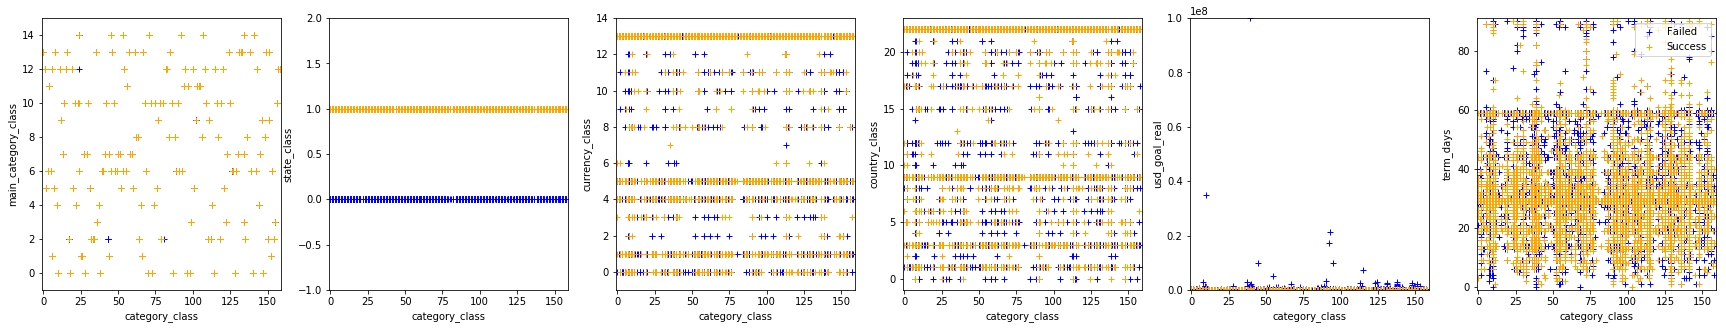

x1=main_category_class


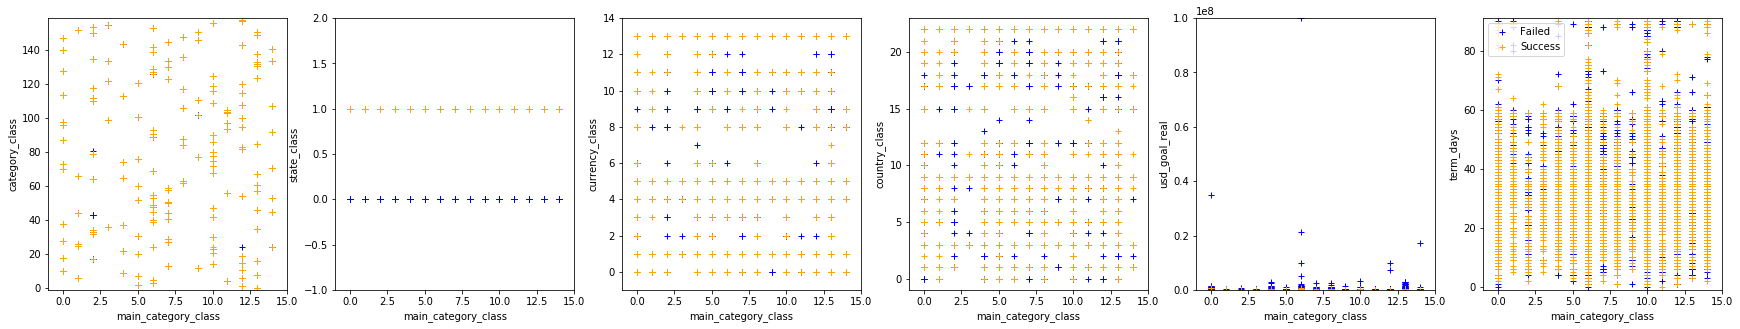

x1=state_class


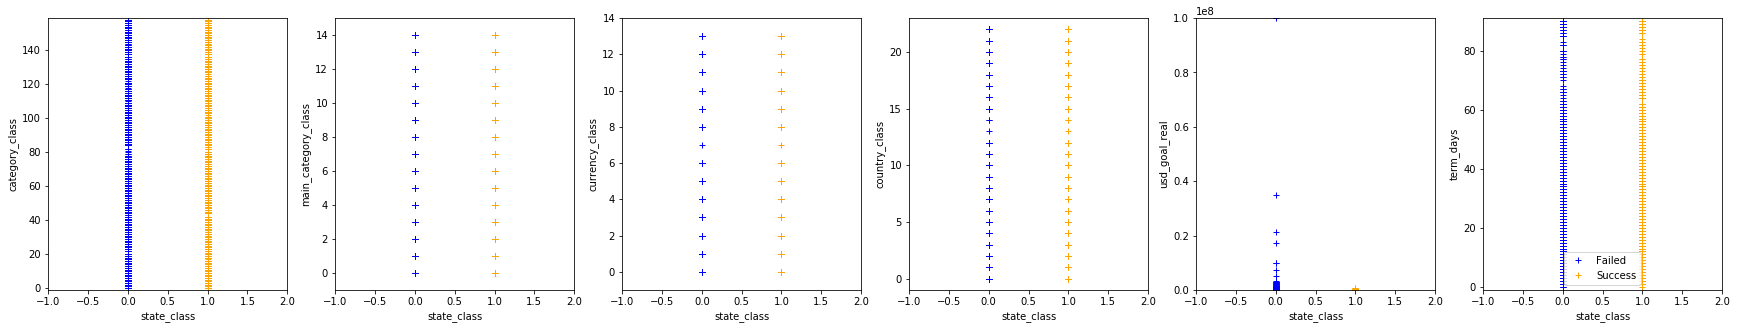

x1=currency_class


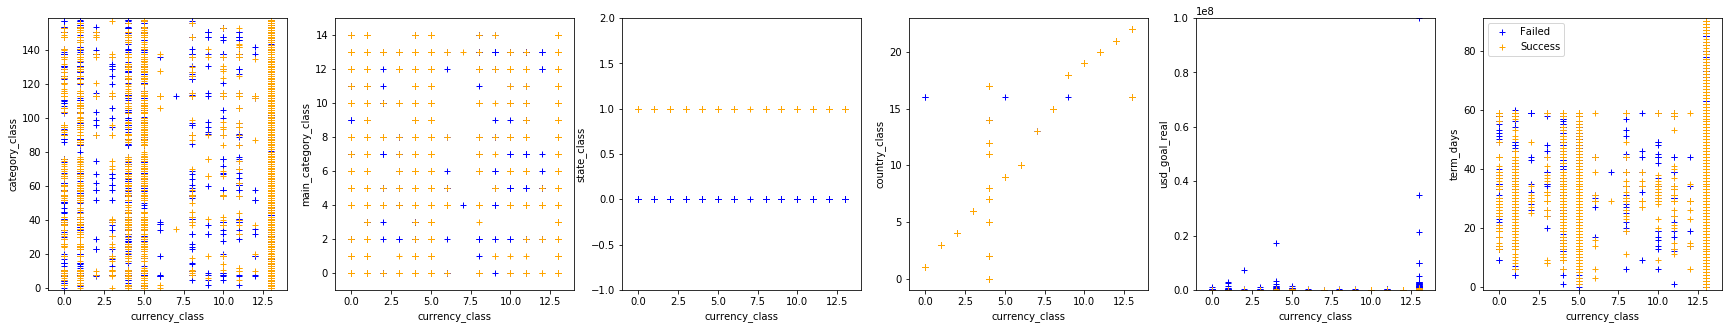

x1=country_class


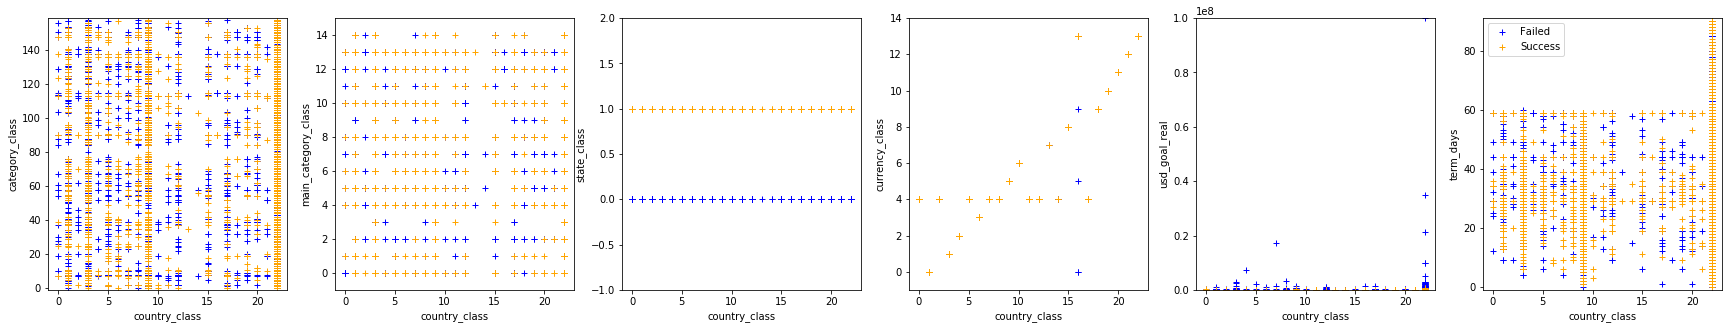

x1=usd_goal_real


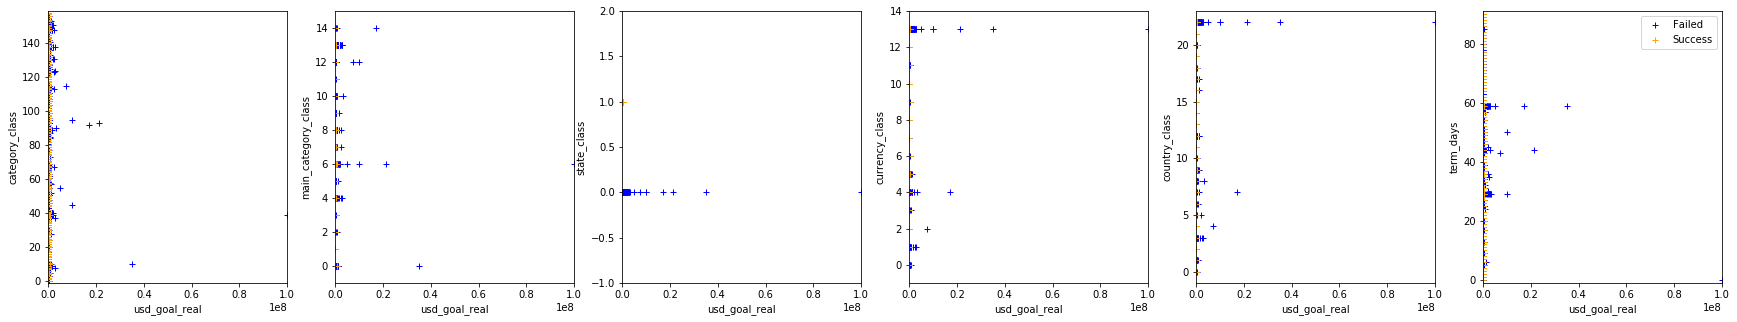

x1=term_days


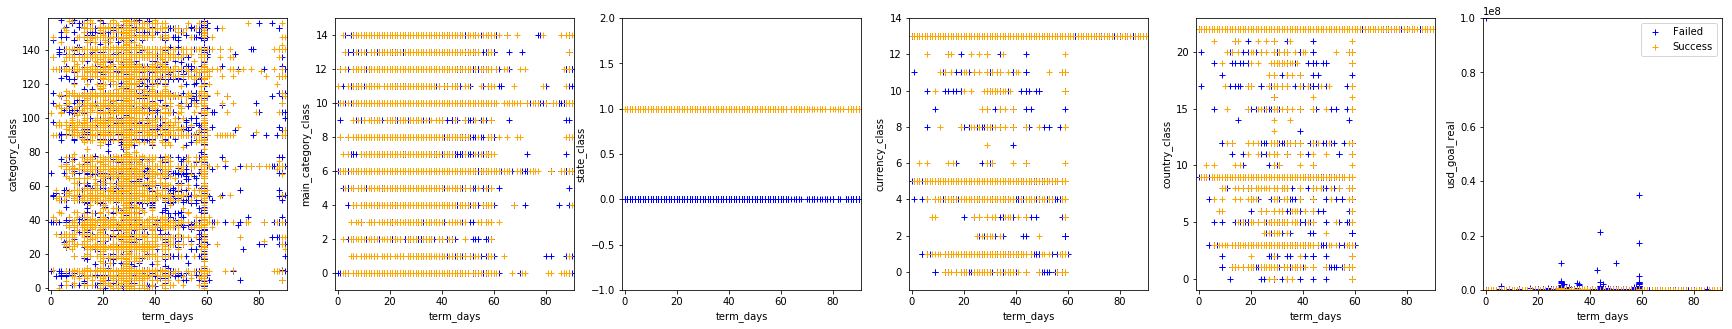

In [10]:
# 2変数間でグラフ化してみる
# グラフ描画関数
def DrawGraph(successX1, successX2, failedX1, failedX2, lblX1, lblX2, index):
    xMin = np.min([np.min(successX1), np.min(failedX1)])
    xMax = np.max([np.max(successX1), np.max(failedX1)])
    yMin = np.min([np.min(successX2), np.min(failedX2)])
    yMax = np.max([np.max(successX2), np.max(failedX2)])
    
    plt.subplot(1, 6, index)
    
    # 失敗したデータ
    plt.plot(failedX1, failedX2, "+", color="blue", label = "Failed")
    # 成功したデータ(成功したデータの方が少ないので後から書かないと上書きされて見えない)
    plt.plot(successX1, successX2, "+", color="orange", label = "Success")
    
    plt.xlim([xMin - 1, xMax + 1])
    plt.ylim([yMin - 1, yMax + 1])
    plt.xlabel(lblX1)
    plt.ylabel(lblX2)
    
cols = ["category_class", "main_category_class", "state_class", "currency_class", "country_class", "usd_goal_real", "term_days"]
for i in range(7):
    print("x1={:}".format(cols[i]))
    graphIndex = 1
    plt.figure(figsize=(30,5))
    for j in range(7):
        if i == j:
            continue
        DrawGraph(df_success[cols[i]].values, df_success[cols[j]].values,
                  df_failed[cols[i]].values, df_failed[cols[j]].values,
                 cols[i], cols[j], graphIndex)
        graphIndex = graphIndex + 1
    plt.legend(loc='best')
    plt.show()

成功したケース、失敗したケースにおいて、2変数間で顕著な差が見られることはない

### 3. 学習

In [24]:
# カテゴリ変数をそのまま学習データに使うのはよくないらしい
# 特に今は名義的に付与した数値なので、データそのものに大小関係はない
# One-hotベクトルにするとよいらしいのでそうしてみる
# とりあえず全部One-hotベクトルにしてみる
#category_class_dummy = pd.get_dummies(df_success_or_failed["category_class"], prefix="category")
main_category_class_dummy = pd.get_dummies(df_success_or_failed["main_category_class"], prefix="main_category")
currency_class_dummy = pd.get_dummies(df_success_or_failed["currency_class"], prefix="currency")
#country_class_dummy = pd.get_dummies(df_success_or_failed["country_class"], prefix="country")
# 学習用データ
#df_for_learning = pd.concat([df_success_or_failed, category_class_dummy, 
#                             main_category_class_dummy, currency_class_dummy, country_class_dummy], axis = 1)
df_for_learning = pd.concat([df_success_or_failed, main_category_class_dummy, currency_class_dummy], axis = 1)

# 不要なカラム削除
for col in ["category", "main_category", "state", "currency", "deadline", 
            "launched", "country", "category_class", "main_category_class", "currency_class", "country_class"]:
    df_for_learning = df_for_learning.drop(col, axis = 1)

In [14]:
# 欠損したデータはないことを確認
#display(df_for_learning.count())

In [25]:
# 目的変数
y = df_for_learning["state_class"].values
df_for_learning = df_for_learning.drop("state_class", axis = 1)
# 説明変数
x = df_for_learning.values

# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(x, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### 4. 評価(識別精度などの確認)

In [28]:
# ラベルを予測
y_pred = clf.predict(x)

# Accuracy
accuracy = accuracy_score(y, y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# 対数尤度を表示
print("対数尤度 = {:.3f}".format(- log_loss(y, y_pred)))
# Accuracy(正答率)を表示
print("Accuracy = {:.3f}%".format(accuracy * 100))
# Precision(適合率)
print("Precision(適合率) = {:.3f}%".format(precision[0] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[0] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[0] * 100))

# お金集める側は「Precision」、投資する側は「Recall」に興味があるのか

対数尤度 = -13.577
Accuracy = 60.691%
Precision(適合率) = 70.745%
Recall(再現率) = 58.075%
F1-score(F1値) = 63.787%


In [29]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,114825,82894
正解 = successful,47483,86473
